In [47]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_absolute_error, balanced_accuracy_score, confusion_matrix
import pymongo

mongohost = "192.168.0.246"
mongoport = 15213
collection = 'MLresults_resub'

# instantiate the mongo client
client = pymongo.MongoClient(mongohost, mongoport)
# get handle to database
db = client.ferret
plt.rcParams['svg.fonttype'] = 'none'

## count matrix

In [53]:
subj = ['14-18','16-18','13-18','15-18']
states = [2,3,3,3]
optimalFeats = [[3,6], [5,6],[1,3,4,9],[2,5,9]]
optimalML = ["Linear SVM", "Linear SVM", "Nearest Neighbors", "Nearest Neighbors"]
location = ['S2','S3','S3','S1S1']

resultDict = {}
for isub, iFeat, iClf, iLoc, iNumStates in zip(subj, optimalFeats, optimalML, location, states):
    asd = db[collection].find({"subject":isub,
                "classifier": iClf,
                "feats":iFeat,
                "locs": iLoc})
    
    resultDict[isub] = np.reshape(np.array(asd[0]['confMat']),(iNumStates,iNumStates),None)
    
print resultDict

{'16-18': array([[690.,  10.,   0.],
       [160., 503.,  37.],
       [  9.,  98., 593.]]), '15-18': array([[319., 153., 128.],
       [  0., 600.,   0.],
       [ 54., 100., 446.]]), '14-18': array([[2449.,  551.],
       [ 228., 2772.]]), '13-18': array([[523.,  77.,   0.],
       [ 49., 469.,  82.],
       [  8., 132., 460.]])}


In [58]:
# count14 = np.array([[1152.,  348.],[ 207., 1293.]])
# count16 = np.array([[607.,  91.,   2.],[ 47., 653.,   0.],[100., 102., 498.]])
# count13 = np.round(np.array([[600.,   0.,   0.],[  0., 332., 268.],[  0.,  44., 556.]])/600*700)
# count15 = np.round(np.array([[459., 110.,  31.],[ 89., 412.,  99.],[  0.,  28., 572.]])/600*700)
# count29 = np.array([[964., 536.],[508., 992.]])

count14 = resultDict['14-18']
count16 = resultDict['16-18']
count13 = np.round(resultDict['13-18']/600*700)
count15 = np.round(resultDict['15-18']/600*700)

# print np.sum(count15,1)

## accuracies per subject

In [59]:
trueLabels = []
y_pred = []
for countArray, subj in zip([count16, count13, count15], ['16','13','15']):
    print 'subject '+ subj 
    subj_trueLabels = [1]*int(sum(countArray[0,:]))+[2]*int(sum(countArray[1,:]))+[3]*int(sum(countArray[2,:]))
    subj_predLabels = ([1]*int(countArray[0,0])+[2]*int(countArray[0,1])+ [3]*int(countArray[0,2])
              +[1]*int(countArray[1,0])+[2]*int(countArray[1,1])+ [3]*int(countArray[1,2])
              +[1]*int(countArray[2,0])+[2]*int(countArray[2,1])+ [3]*int(countArray[2,2]))
    subj_accuracy = accuracy_score(subj_trueLabels, subj_predLabels)*100
    
    classError_tmp = sum([ x==y for (x,y) in zip(subj_trueLabels, subj_predLabels)]) / float(len(subj_trueLabels))
#     classError_tmp = mean_absolute_error(subj_trueLabels, subj_predLabels)
    
    n = len(subj_trueLabels)
    CI_tmp = 1.96 * np.sqrt( (classError_tmp * (1 - classError_tmp)) / n)
    
    print 'Accuracy: %0.4f CI = %0.04f +/- %0.04f' %(subj_accuracy, classError_tmp, CI_tmp)
    
    trueLabels = trueLabels+subj_trueLabels
    y_pred = y_pred+subj_predLabels


subject 16
Accuracy: 85.0476 CI = 0.8505 +/- 0.0153
subject 13
Accuracy: 80.6667 CI = 0.8067 +/- 0.0169
subject 15
Accuracy: 75.8456 CI = 0.7585 +/- 0.0183


## metrics for 3 states

    ### precision = positive predictive value
    ### recall = sensitivity
    ### F1 score = precision * recall /(precision + recall)

In [60]:
confMat = confusion_matrix(trueLabels, y_pred)
print confMat 

[[1672  278  149]
 [ 217 1750  133]
 [  81  369 1650]]


In [61]:
classError_3 = mean_absolute_error(trueLabels, y_pred)
print classError_3

n = len(trueLabels)
CI_3 = 1.96 * np.sqrt( (classError_3 * (1 - classError_3)) / n)
print CI_3

0.23130655659628513
0.010413358672491569


In [62]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(trueLabels, y_pred, target_names=['base', 'early', 'late']))
print( 'accuracy', accuracy_score(trueLabels, y_pred))

# specificity
# base
tn_base = float(np.sum(confMat[[1,2],[1,2]]))
fp_base = np.sum(confMat[[1,2],0])
specBase = tn_base/(tn_base+fp_base)
print ('base spec', specBase)

# early
tn_early = float(np.sum(confMat[[0,2],[0,2]]))
fp_early = np.sum(confMat[[0,2],1])
specEarly = tn_early/(tn_early+fp_early)b
print ('early spec', specEarly)

# late
tn_late = float(np.sum(confMat[[0,1],[0,1]]))
fp_late = np.sum(confMat[[0,1],2])
specLate = tn_late/(tn_late+fp_late)
print ('late spec', specLate)

              precision    recall  f1-score   support

        base       0.85      0.80      0.82      2099
       early       0.73      0.83      0.78      2100
        late       0.85      0.79      0.82      2100

   micro avg       0.81      0.81      0.81      6299
   macro avg       0.81      0.81      0.81      6299
weighted avg       0.81      0.81      0.81      6299

('accuracy', 0.8052071757421813)
('base spec', 0.9194159004867496)
('early spec', 0.8369866465104561)
('late spec', 0.923866090712743)


## TNR and TPR

In [90]:
fn_late = float(confMat[2,0]+confMat[2,1])
tp_late = confMat[2,2]
false_negative_late = fn_late/(fn_late+tp_late)
print 'FNR: %f' %false_negative_late

fp_late = np.sum(confMat[[0,1],2])
tn_late = float(confMat[0,0]+confMat[1,1])
false_positive_late = fp_late/(fp_late+tn_late)
print 'FPR: %f' %false_positive_late

FNR: 0.214286
FPR: 0.076134


## metrics for 2 states
    ### in binary classification, recall of the positive class is also known as “sensitivity”; 
    ### recall of the negative class is “specificity”

In [63]:
true14 = [1]*int(sum(count14[0,:]))+[2]*int(sum(count14[1,:]))
pred14 = ([1]*int(count14[0,0])+[2]*int(count14[0,1])
          +[1]*int(count14[1,0])+[2]*int(count14[1,1]))

confMat14 = confusion_matrix(true14, pred14)
print confMat14

[[2449  551]
 [ 228 2772]]


In [64]:
classError_2 = sum([ x==y for (x,y) in zip(true14, pred14)]) / float(len(true14))

n = len(trueLabels)
CI_2 = 1.96 * np.sqrt( (classError_2 * (1 - classError_2)) / n)

accuracy14 = accuracy_score(true14, pred14)*100

print 'Accuracy: %0.4f CI = %0.04f +/- %0.04f' %(accuracy14, classError_2, CI_2)

Accuracy: 87.0167 CI = 0.8702 +/- 0.0083


In [65]:
print(classification_report(true14, pred14, target_names=['early', 'late']))

# specificity
# base
tn_base14 = float(np.sum(confMat14[1,1]))
fp_base14 = np.sum(confMat14[1,0])
specBase14 = tn_base14/(tn_base14+fp_base14)
print ('base spec', specBase14)

# early
tn_early14 = float(np.sum(confMat14[0,0]))
fp_early14 = np.sum(confMat14[0,1])
specEarly14 = tn_early14/(tn_early14+fp_early14)
print ('early spec', specEarly14)


              precision    recall  f1-score   support

       early       0.91      0.82      0.86      3000
        late       0.83      0.92      0.88      3000

   micro avg       0.87      0.87      0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000

('base spec', 0.924)
('early spec', 0.8163333333333334)


### TNR and TPR

In [88]:
fn_late = float(confMat14[1,0])
tp_late = confMat14[1,1]
false_negative_late14 = fn_late/(fn_late+tp_late)
print 'FNR: %f' % false_negative_late14

fp_late = float(confMat14[0,1])
tn_late = confMat14[0,0]
false_positive_late14 = fp_late/(fp_late+tn_late)
print 'FPR: %f' % false_positive_late14

FNR: 0.076000
FPR: 0.183667


## combined confusion matrix

Text(452.236,0.5,'true labels')

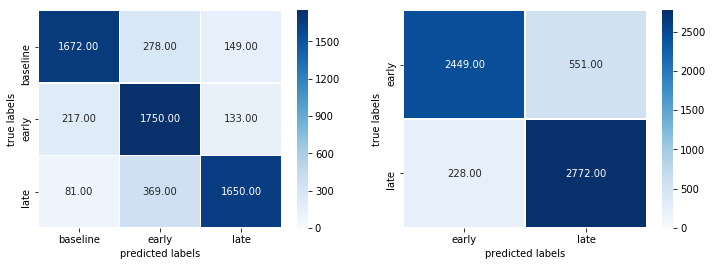

In [79]:
#### totalCounts = count16+count13+count15
f,ax = plt.subplots(1,2,figsize=(12,4))
sns.heatmap(totalCounts, cmap='Blues' ,annot=True,fmt='.02f',linewidths=.5,xticklabels=['baseline','early','late'], yticklabels=['baseline','early','late'],vmax=np.max(totalCounts),vmin=0, ax=ax[0])
sns.heatmap(count14, cmap='Blues' ,annot=True,fmt='.02f',linewidths=.5,xticklabels=['early','late'], yticklabels=['early','late'],vmax=np.max(count14),vmin=0,ax=ax[1])
ax[0].set_xlabel('predicted labels')
ax[0].set_ylabel('true labels')

ax[1].set_xlabel('predicted labels')
ax[1].set_ylabel('true labels')